![Cradlepoint](logo.svg)

---

# **PART 4** - Use Cases

#### There are many powerful ways to leverage the NCM API.  

#### Let's explore some other use cases and methods.

---

#### This section will cover:  
- Create an account (POST)

#### Custom Reporting: net_device_usage_samples and net_device_signal_samples for given timeframe:



## Create an account (POST)

When you want to create a new resource, such as a group or (sub)account, you use the **.post()** method from the requests library.  You need to pass the required parameters to create that new resource.  In this example, we will create a new _account_.  

The documentation on https://developer.cradlepoint.com for the **/accounts/** endpoint indicates (*) which fields are required for **POST**:
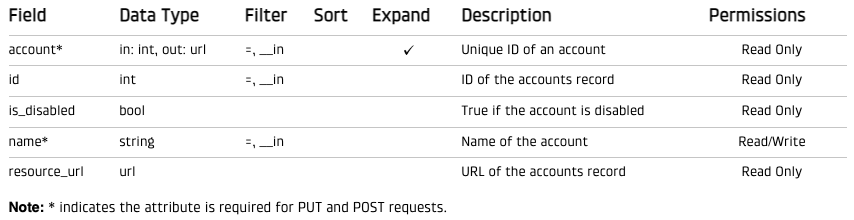
  
The required fields for creating an account are a name and the parent **account** where you intend to create it.

---

#### GET /accounts/

For the parent **account** use the account **resource_url** from Part 2 and assign it to a new variable _account_url_:

```python
account_url = 'https://www.cradlepointecm.com/api/v2/accounts/12345/'
```

#### Try it out!
_Assign your account's **resource_url** from Part 2 to_ account_url

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  

### Create JSON Request Body

Create the body of the request in JSON format to create the subaccount.  It needs to include the required fields **account* and **name**.  

You can name it anything you like.  

```python
body = {
    "account": account_url,
    "name": "Customer ABC"
}
```
---

#### Try it out!
_Create your JSON body and give your account a name._

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  

### Make a POST Request

Use the requests module to make a **post** request to the **/accounts/** endpoint, and pass your _body_ as the **json** keyword argument:

---

```python
response = requests.post(f'{base_url}/groups/', headers=headers, json=body)
print(response)
```

---

#### Try it out!
_Make a post request to create your new account_

Type the code above into the input box below.  
Then press **shift-enter** to execute it.  

## Custom Reporting

Many custom reports can be generated from the data available in the NCM API.  Below is an example of printing out a report of data usage and signal values for a given timeframe.  This provides a comprehensive example of pagination and data correlation.

In [ ]:
# net_device_usage_samples and net_device_signal_samples for given timeframe

import json
import requests


API_OBJ_REQUEST_SIZE = 100
API_OBJ_RESPONSE_SIZE = 500

START_DATE = '2023-03-16'
END_DATE = '2023-03-17'


# Chunk lists into blocks
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


# Get the next url, at completion return None
def next_url(resp):
    if resp['meta']['next']:
        url = resp['meta']['next']
    else:
        url = None

    return url


# Fill in your API keys here
headers = {
    'X-ECM-API-ID': 'YOUR',
    'X-ECM-API-KEY': 'KEYS',
    'X-CP-API-ID': 'GO',
    'X-CP-API-KEY': 'HERE',
    'Content-Type': 'application/json'
}


# Get net_devices
net_device_ids = set()
url = 'https://www.cradlepointecm.com/api/v2/net_devices/?limit={}'. \
    format(API_OBJ_RESPONSE_SIZE)
while url:
    req = requests.get(url, headers=headers)
    resp = req.json()
    for net_device in resp['data']:
        net_device_ids.add(int(net_device['id']))
    url = next_url(resp)


# Get usage samples
print('bytes_in,bytes_out,created_at,created_at_timeuuid,'
      'net_device,period,uptime')
for net_devices in chunker(sorted(net_device_ids), API_OBJ_REQUEST_SIZE):
    url = 'https://www.cradlepointecm.com/api/v2/net_device_usage_samples/' \
        '?limit={}'.format(API_OBJ_RESPONSE_SIZE)
    url += '&net_device__in={}'.format(','.join(map(str, net_devices)))
    url += '&created_at__gt={}&created_at__lt={}'.format(START_DATE, END_DATE)
    url += '&order_by=created_at_timeuuid'

    while url:
        req = requests.get(url, headers=headers)
        resp = req.json()
        if (len(resp['data']) > 0):
            for net_device in resp['data']:
                print('{},{},{},{},{},{},{}'.format(
                    net_device['bytes_in'],
                    net_device['bytes_out'],
                    net_device['created_at'],
                    net_device['created_at_timeuuid'],
                    net_device['net_device'],
                    net_device['period'],
                    net_device['uptime']))
        url = next_url(resp)


# Get signal samples
print('created_at,created_at_timeuuid,ecio,net_device,rssi,'
      'signal_percent,sinr,uptime')
for net_devices in chunker(sorted(net_device_ids), API_OBJ_REQUEST_SIZE):
    url = 'https://www.cradlepointecm.com/api/v2/net_device_signal_samples/' \
        '?limit={}'.format(API_OBJ_RESPONSE_SIZE)
    url += '&net_device__in={}'.format(','.join(map(str, net_devices)))
    url += '&created_at__gt={}&created_at__lt={}'.format(START_DATE, END_DATE)
    url += '&order_by=created_at_timeuuid'

    while url:
        req = requests.get(url, headers=headers)
        resp = req.json()
        if (len(resp['data']) > 0):
            for net_device in resp['data']:
                print('{},{},{},{},{},{},{},{}'.format(
                    net_device['created_at'],
                    net_device['created_at_timeuuid'],
                    net_device['ecio'],
                    net_device['net_device'],
                    net_device['rssi'],
                    net_device['signal_percent'],
                    net_device['sinr'],
                    net_device['uptime']))
        url = next_url(resp)


## Upgrade routers in batches

In [ ]:
# Move batches (chunks) of routers from one group to another for rolling upgrades.

from ncm import ncm
import time

api_keys = {
    'X-ECM-API-ID': 'YOUR',
    'X-ECM-API-KEY': 'KEYS',
    'X-CP-API-ID': 'GO',
    'X-CP-API-KEY': 'HERE'
}

src_group_id = 12345  # Source group of routers
dest_group_id = 54321  # Destination group of routers
chunk_size = 5  # number of routers to move at a time
wait_time = 600  # seconds to wait between moves

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

n = ncm.NcmClient(api_keys=api_keys)
routers = n.get_routers_for_group(src_group_id)
for chunk in chunks(routers, chunk_size):
    for router in chunk:
        n.assign_router_to_group(router["id"], dest_group_id)
    time.sleep(wait_time)